# SBERT
use for sentence embedding.

In [3]:
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

In [4]:
import pandas as pd

In [6]:
df = pd.read_csv('../datasets.csv')
df

,topic,length,AI_model,humanizer,AI_essay,humanized_essay
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...
...,...,...,...,...,...,...
175,5,3,gpt4.0,Grammarly,Childhood is often remembered through the lens...,Childhood is frequently recalled as a period m...
176,5,3,gpt4.0,HumanizeAI,Childhood is often remembered through the lens...,Childhood is often remembered as a realm of si...
177,5,3,gpt4.0,Quillbot,Childhood is often remembered through the lens...,Childhood is frequently viewed through the pri...
178,5,3,gpt4.0,UndetectableAI,Childhood is often remembered through the lens...,People tend to recall their childhood through ...


# No need for preprocessing
With SBERT, traditional NLP preprocessing like removing stopwords or stemming is unneccessary.

# Chunk the text
Most of the essays are longer than max_token of all available SBERT model, therefore, we need to chunk it into pieces with smooth sliding window.

In [7]:
def chunk_text(tokenizer, text, max_tokens = 256, stride = 50):
    tokens = tokenizer.encode(text, add_special_tokens = False)
    if len(tokens) <= max_tokens:
        return [text]
    chunks = []
    step = max_tokens - stride
    for i in range(0, len(tokens), step):
        chunk_tokens = tokens[i:i + max_tokens]
        chunk_text = tokenizer.decode(chunk_tokens)
        chunks.append(chunk_text)
        if i + max_tokens >= len(tokens):
            break
    return chunks

In [8]:
tokenizer = model.tokenizer
df_chunked = df.copy()
df_chunked['chunked_AI_essay'] = df_chunked['AI_essay'].apply(lambda x: chunk_text(tokenizer, x))
df_chunked['chunked_humanized_essay'] = df_chunked['humanized_essay'].apply(lambda x: chunk_text(tokenizer, x))
df_chunked.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (326 > 256). Running this sequence through the model will result in indexing errors


,topic,length,AI_model,humanizer,AI_essay,humanized_essay,chunked_AI_essay,chunked_humanized_essay
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...,[the integration of social media into the live...,[the way social media has woven itself into th...
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...,[the integration of social media into the live...,[social media has become a big part of young p...
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...,[the integration of social media into the live...,[the penetration of social media into the live...
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...,[the integration of social media into the live...,[social media ' s introduction into young peop...
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...,[the integration of social media into the live...,[Young people face a harmful environment throu...


# Calculate Cosine Similarity

In [9]:
import numpy as np
def calculate_aggregated_similarity(model, ai_chunk, humanized_chunk, max_tokens, stride):
    ai_embeddings = model.encode(ai_chunk, convert_to_tensor=True, show_progress_bar=False)
    humanized_embeddings = model.encode(humanized_chunk, convert_to_tensor=True, show_progress_bar=False)
    cosine_scores = util.cos_sim(ai_embeddings, humanized_embeddings)
    cosim_matrix = cosine_scores.cpu().numpy()

    #For any chunk in AI essay, use the maximum cosine similarity with any chunk in humanized essay
    max_cosim_for_ai = np.max(cosim_matrix, axis=1)
    mean_max_cosim = np.mean(max_cosim_for_ai)

    #For any chunk in humanized essay, use the maximum cosine similarity with any chunk in AI essay
    max_cosim_for_humanized = np.max(cosim_matrix, axis=0)
    mean_max_cosim_humanized = np.mean(max_cosim_for_humanized)

    final_score = (mean_max_cosim + mean_max_cosim_humanized) / 2
    return final_score

In [10]:
df_cosim = df_chunked.copy()
df_cosim['SBERT_cosim'] = None
for index, row in df_cosim.iterrows():
    ai_chunks = row['chunked_AI_essay']
    humanized_chunks = row['chunked_humanized_essay']
    cosim_score = calculate_aggregated_similarity(model, ai_chunks, humanized_chunks, max_tokens=256, stride=50)
    df_cosim.at[index, 'SBERT_cosim'] = cosim_score
df_cosim.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,topic,length,AI_model,humanizer,AI_essay,humanized_essay,chunked_AI_essay,chunked_humanized_essay,SBERT_cosim
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...,[the integration of social media into the live...,[the way social media has woven itself into th...,0.850309
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...,[the integration of social media into the live...,[social media has become a big part of young p...,0.754118
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...,[the integration of social media into the live...,[the penetration of social media into the live...,0.915031
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...,[the integration of social media into the live...,[social media ' s introduction into young peop...,0.93035
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...,[the integration of social media into the live...,[Young people face a harmful environment throu...,0.850842


In [12]:
#remove the outlier
df_cosim_cleaned = df_cosim.drop(index=161)
df_cosim_cleaned.reset_index(inplace=True, drop=True)
df_cosim_humanizer_length = df_cosim_cleaned.groupby(['humanizer', 'length'])['SBERT_cosim'].mean().reset_index()
df_cosim_humanizer_length['length'] = df_cosim_humanizer_length['length'].map({1: 'short', 2: 'medium', 3: 'long'})
df_cosim_humanizer_length

,humanizer,length,SBERT_cosim
0,AIHumanizer,short,0.877779
1,AIHumanizer,medium,0.882853
2,AIHumanizer,long,0.879796
3,Grammarly,short,0.873244
4,Grammarly,medium,0.851462
5,Grammarly,long,0.839034
6,HumanizeAI,short,0.86799
7,HumanizeAI,medium,0.877677
8,HumanizeAI,long,0.871362
9,Quillbot,short,0.903334


In [13]:
df_cosim_cleaned = df_cosim.drop(index=161)
df_cosim_cleaned.reset_index(inplace=True, drop=True)
df_cosim_humanizer = df_cosim_cleaned.groupby('humanizer')['SBERT_cosim'].mean().reset_index()
df_cosim_humanizer = df_cosim_humanizer.sort_values(by='SBERT_cosim')
df_cosim_humanizer

,humanizer,SBERT_cosim
4,UndetectableAI,0.839513
1,Grammarly,0.85458
5,writehuman.ai,0.859876
2,HumanizeAI,0.872343
0,AIHumanizer,0.880143
3,Quillbot,0.912473


# Visualization

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
custom_palette = sns.color_palette(['#B08A4C', '#675200', '#250000'])
sns.set_palette(custom_palette)

/var/folders/sl/36wj2dpn1fvgpr5ydrsxz8wm0000gn/T/ipykernel_18941/146031778.py:19: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 4
  ax.legend(handles=handles, labels=labels, title='Essay Length / Mean', bbox_to_anchor=(1, 1), loc='upper left')


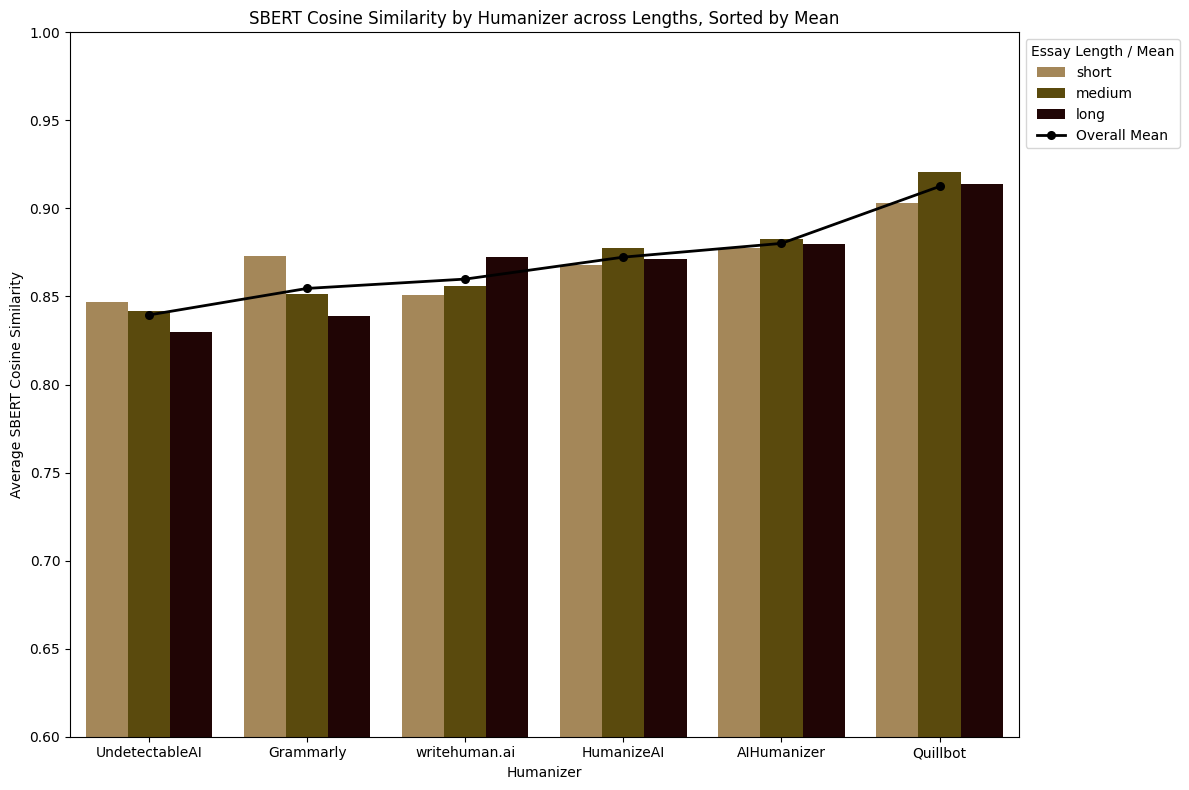

In [16]:
sorted_humanizer_order = df_cosim_humanizer['humanizer'].tolist()

from matplotlib.lines import Line2D
plt.figure(figsize=(12,8))

#bar plot
ax = sns.barplot(data=df_cosim_humanizer_length, x='humanizer', y='SBERT_cosim', hue='length', order=sorted_humanizer_order, )

#line plot of mean
sns.pointplot(data=df_cosim_humanizer, x='humanizer', y='SBERT_cosim', color='black', markers='o', label='Overall Mean', order=sorted_humanizer_order, linewidth=2)

plt.title('SBERT Cosine Similarity by Humanizer across Lengths, Sorted by Mean')
plt.xlabel('Humanizer')
plt.ylabel('Average SBERT Cosine Similarity')

handles, labels = ax.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='black', marker='_', linestyle='-', markersize=3, linewidth=0.4))
ax.legend(handles=handles, labels=labels, title='Essay Length / Mean', bbox_to_anchor=(1, 1), loc='upper left')
#set y-axis limit
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

# Save temporary df for later use

In [18]:
df_chunked.to_parquet('./df_SBERT_chunked.parquet', index=False)

In [19]:
df_cosim.to_parquet('./df_SBERT_cosim.parquet', index=False)